# Kubernetes Distributions Serverless Performance

# Abstract
Serverless computing, especially when deployed at the edge of the network is seen as an enabling technology for the future development of more complex IoT systems. However, special care must be taken when deploying new edge infrastructures for serverless workloads in terms of resource usage and network connectivity. Inefficient utilization of the available computing resources might easily cancel out the benefits acquired by moving the equipment closer to the edge, namely the reduced communication latency. Containers, together with the Kubernetes container orchestrator are used by many serverless platforms today. We evaluate the performance of three different Kubernetes distributions – full-fledged Kubernetes, K3s, and MicroK8s when deployed in a resource constrained environment at the edge. We use the OpenFaaS serverless platform and employ 14 different benchmarks divided into three separate categories to evaluate various aspects of the execution performance of the distributions. Four different test types are performed focusing on cold-start latency, serial execution performance, parallel execution using a single replica, and parallel execution utilizing different autoscaling strategies. Our results show that the two Kubernetes distributions specifically designed for deployment on edge nodes, K3s and MicroK8s, show better performance in comparison to a more complex full-fledged deployment.

# Analysis

The following libraries need to be installed in the environment before continuing with the data analysis.

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install seaborn

In [1]:
import pandas as pd
import glob
import re
import os
import matplotlib.pyplot as plt

from scipy import stats
import seaborn as sns
import math

In [2]:
TEST_PLATFORMS = ['kubespray', 'k3s', 'microk8s']
sns.set_style("ticks",{'axes.grid' : True})

## 01 - Analyzing Cold Start Delays

We evaluate the cold start delays for different platforms across the 14 different function types.

In [3]:
df_cold_start_container = pd.DataFrame()

In [4]:
kubespray_cold_start_container = pd.read_csv('data/kubespray/01-cold-start/pod_startup_times/kubespray-delay-all.csv')
k3s_cold_start_container = pd.read_csv('data/k3s/01-cold-start/pod_startup_times/k3s-delay-all.csv')
microk8s_cold_start_container = pd.read_csv('data/microk8s/01-cold-start/pod_startup_times/microk8s-delay-all.csv')

kubespray_cold_start_container['platform'] = 'kubespray'
k3s_cold_start_container['platform'] = 'k3s'
microk8s_cold_start_container['platform']='microk8s'

df_cold_start_container = df_cold_start_container.append(kubespray_cold_start_container)
df_cold_start_container = df_cold_start_container.append(k3s_cold_start_container)
df_cold_start_container = df_cold_start_container.append(microk8s_cold_start_container)

Increasing the default number of shown rows before starting with the data exploration...

In [5]:
pd.set_option('display.max_rows', 250)

Exploring the data by looking at the mean cold start delay per platform.

In [6]:
print(df_cold_start_container.groupby(['platform']).mean())

              delay
platform           
k3s        5.627143
kubespray  6.467857
microk8s   5.622857


Exploring the data by looking at the mean cold start delay per platform and app.

In [7]:
print(df_cold_start_container.groupby(['platform', 'app']).mean())

                              delay
platform  app                      
k3s       chameleon            5.73
          dd                   5.62
          float-operation      5.69
          gzip-compression     5.66
          image-processing     5.59
          json-dumps-loads     5.54
          linpack              5.55
          matmul               5.67
          model-training       5.51
          pyaes                5.45
          random-disk-io       5.71
          s3-download-speed    5.56
          sequential-disk-io   5.94
          video-processing     5.56
kubespray chameleon            6.52
          dd                   6.31
          float-operation      6.27
          gzip-compression     6.50
          image-processing     6.56
          json-dumps-loads     6.50
          linpack              6.44
          matmul               6.36
          model-training       6.66
          pyaes                6.46
          random-disk-io       6.60
          s3-download-speed 

Plotting the average cold start delay per platform

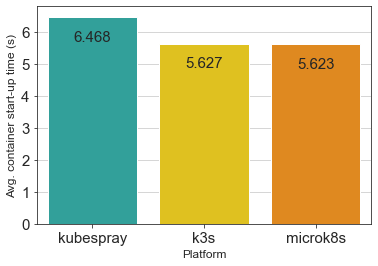

In [8]:
cold_start_mean_bars = sns.barplot(data=df_cold_start_container.groupby(['platform']).mean().reset_index(), x='platform', y='delay', order=TEST_PLATFORMS, errwidth=0, palette=['lightseagreen', 'gold', 'darkorange'])
cold_start_mean_bars.set_xlabel('Platform', fontsize=12)
cold_start_mean_bars.set_ylabel('Avg. container start-up time (s)', fontsize=12)
cold_start_mean_bars.tick_params(labelsize=15)
for ax in cold_start_mean_bars.patches:
    cold_start_mean_bars.annotate(format(ax.get_height(), '.3f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()), ha = 'center', va = 'center', xytext = (0, -20), textcoords = 'offset points', fontsize=15)

In [9]:
fig = cold_start_mean_bars.get_figure()
fig.savefig('01-01-cold_start_mean_bars', bbox_inches='tight', dpi=300)

Further exploration by using box plots to see more details about the data. Extreme outliers have been eliminated to save space on the chart. The median is shown with a pink line.

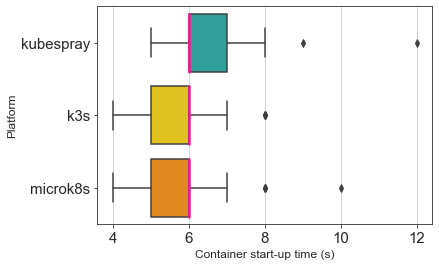

In [10]:
cold_start_boxplot = sns.boxplot(data=df_cold_start_container[df_cold_start_container['delay']<=17], x="delay", y="platform", width=0.8, medianprops=dict(color="deeppink", alpha=1.0, linewidth=2.5), order=TEST_PLATFORMS, palette=['lightseagreen', 'gold', 'darkorange'])
cold_start_boxplot.set_xlabel('Container start-up time (s)', fontsize=12)
cold_start_boxplot.set_ylabel('Platform', fontsize=12)
cold_start_boxplot.tick_params(labelsize=15)
plt.show()

In [11]:
fig = cold_start_boxplot.get_figure()
fig.savefig('01-02-cold_start_boxplot', bbox_inches='tight', dpi=300)

It would be beneficial to visualise the average response times per function. We can use a heatmap for this purpose.

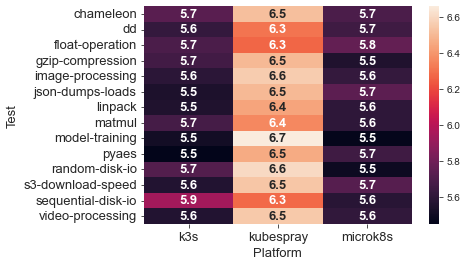

In [12]:
test_cold_start = df_cold_start_container[['app', 'delay', 'platform']]
test_cold_start = test_cold_start.groupby(['app', 'platform']).mean().reset_index()
cold_start_heatmap = sns.heatmap(data=test_cold_start.pivot(index='app', columns='platform', values='delay'), annot=True, annot_kws={'fontsize':13, 'weight': 'bold'})
cold_start_heatmap.set_xlabel('Platform', fontsize=13)
cold_start_heatmap.set_ylabel('Test', fontsize=13)
cold_start_heatmap.tick_params(labelsize=13)
plt.show()

In [13]:
fig = cold_start_heatmap.get_figure()
fig.savefig('01-03-cold_start_heatmap', bbox_inches='tight', dpi=300)

Testing whether the cold-start delays for the different platforms follow the same distribution using a nonparametric three-way Kruskal-Wallis test:

In [14]:
data_kubespray = kubespray_cold_start_container['delay']
data_k3s = k3s_cold_start_container['delay']
data_microk8s = microk8s_cold_start_container['delay']
alpha = 0.05
statistic, pvalue = stats.kruskal(data_kubespray,data_k3s, data_microk8s)
if pvalue > alpha:
    print('Fail to reject H0 - same distribution')
else:
    print('Reject H0 - different distribution')

Reject H0 - different distribution


The null hypothesis failed to be rejected. Let’s test whether K3s and MicroK8s delays have the same distribution, using a nonparametric Mann-Whitney U-test:

In [15]:
alpha = 0.05
statistic, pvalue = stats.mannwhitneyu(data_k3s,data_microk8s)
print(f'The p-value is: {pvalue}')
if pvalue > alpha:
    print('Fail to reject H0 - same distribution')
else:
    print('Reject H0 - different distribution')

The p-value is: 0.20193473974729836
Fail to reject H0 - same distribution


There is not enough evidence to support the case that the cold start delays of K3s and MicroK8s platforms follow different distributions.

In conclusion, Kubespray offers a higher cold-start delay than either K3s or MicroK8s. There is no evidence suggesting difference between the cold-start performance of K3s and MicroK8s.

## 02 - Analyzing Serial Execution

To analyze the serial execution performance, each function has been executed for 5 minutes across all three Kubernetes distributions.

In [16]:
df_serial = pd.DataFrame()

Loading the data into a single data frame...

In [17]:
if os.path.sep == '/':
    regex_escape = '/'
else:
    regex_escape = '\\\\'

test_type= '02'
test_type_description = 'serial_execution'

for test_platform in TEST_PLATFORMS:
    platform_serial_files = glob.glob(f'data/{test_platform}/02-serial-execution/*.csv')
    for file in platform_serial_files:
        test_name = re.findall(f'{regex_escape}(.*).csv', file)[0]
        df_tmp = pd.read_csv(file)
        df_tmp['test_type']=test_type
        df_tmp['test_type_description']=test_type_description
        df_tmp['test_platform']=test_platform
        df_tmp['test_name']=test_name
        df_serial = df_serial.append(df_tmp)

Exploring the mean response time for the various tests across the three different platforms:

In [18]:
print(df_serial.groupby(['test_name', 'test_type_description', 'test_platform']).mean())

                                                               response-time  \
test_name                 test_type_description test_platform                  
chameleon-serial          serial_execution      k3s                22.030736   
                                                kubespray          22.573714   
                                                microk8s           22.216171   
dd-serial                 serial_execution      k3s                 1.027233   
                                                kubespray           1.318654   
                                                microk8s            1.038141   
float-operation-serial    serial_execution      k3s                 7.233514   
                                                kubespray           7.482924   
                                                microk8s            7.131577   
gzip-compression-serial   serial_execution      k3s                 3.721601   
                                        

Calculating the total number of executions for each test during the 5 minutes test interval:

In [19]:
print(df_serial.groupby(['test_name', 'test_type_description', 'test_platform']).size())

test_name                  test_type_description  test_platform
chameleon-serial           serial_execution       k3s               14
                                                  kubespray         14
                                                  microk8s          14
dd-serial                  serial_execution       k3s              293
                                                  kubespray        228
                                                  microk8s         290
float-operation-serial     serial_execution       k3s               42
                                                  kubespray         41
                                                  microk8s          43
gzip-compression-serial    serial_execution       k3s               81
                                                  kubespray         78
                                                  microk8s          79
image-processing-serial    serial_execution       k3s               53
             

Using bar plots to better visualize the number of executions in a 5 minute interval

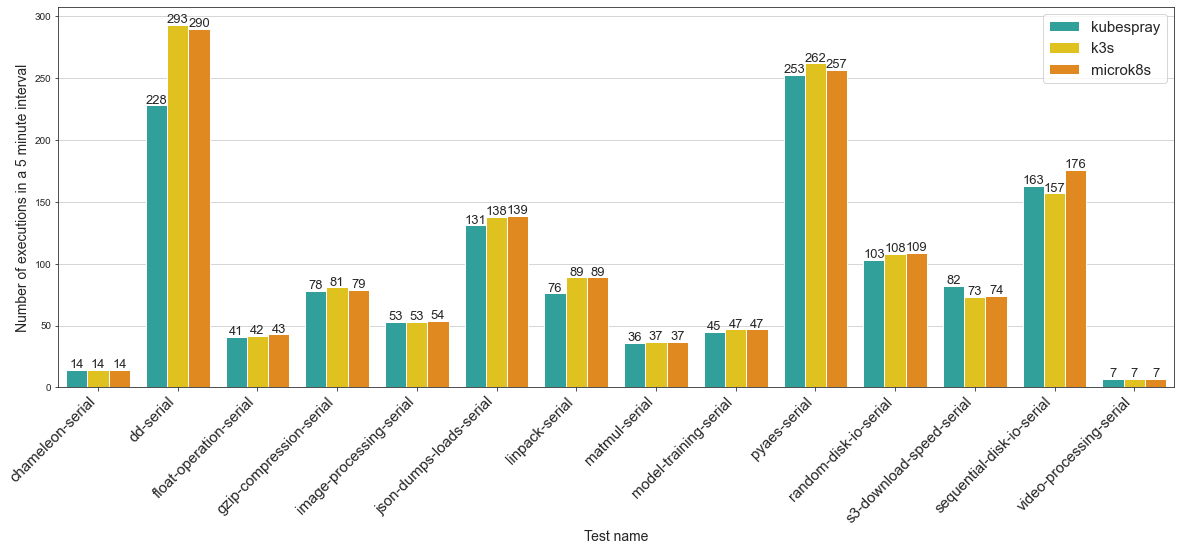

In [20]:
fig = plt.figure(figsize=(20,7))
serial_execution_count_plot = sns.countplot(x='test_name', hue='test_platform', data=df_serial, palette=['lightseagreen', 'gold', 'darkorange'])

for ax in serial_execution_count_plot.patches:
    serial_execution_count_plot.annotate(format(ax.get_height(), '.0f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=13)
serial_execution_count_plot.set_xticklabels(serial_execution_count_plot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=15)
serial_execution_count_plot.set_ylabel('Number of executions in a 5 minute interval', fontsize=14)
serial_execution_count_plot.set_xlabel('Test name', fontsize=14)
serial_execution_count_plot.legend(fontsize=15)
plt.show()

In [21]:
fig = serial_execution_count_plot.get_figure()
fig.savefig('02-03-serial_execution_count_plot', bbox_inches='tight', dpi=300)

Visualizing the average response time for each test function during the 5 minutes test interval:

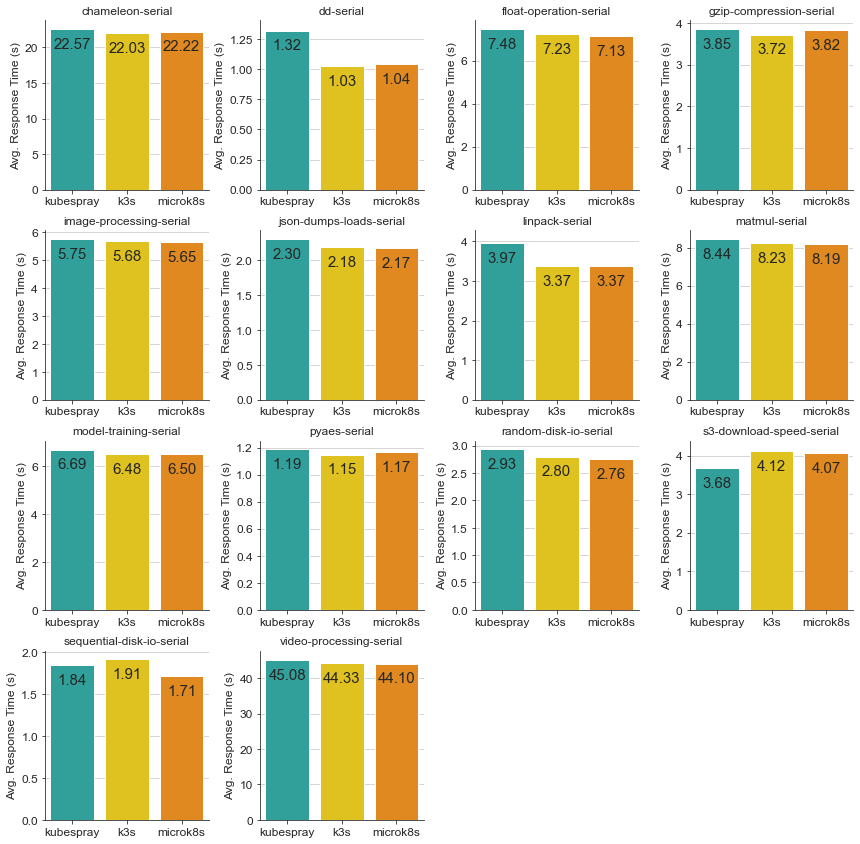

In [22]:
serial_execution_avg_bar_plot = sns.FacetGrid(df_serial, col="test_name", hue='test_platform', col_wrap=4, sharey=False, palette=['lightseagreen', 'gold', 'darkorange'],
                                              sharex=False)
serial_execution_avg_bar_plot = serial_execution_avg_bar_plot.map(sns.barplot, 'test_platform', 'response-time',
                                                                  order=TEST_PLATFORMS, errwidth=0)
serial_execution_avg_bar_plot.set_titles('{col_name}', size=12)
serial_execution_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in serial_execution_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Avg. Response Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

In [23]:
serial_execution_avg_bar_plot.savefig('02-04-serial_execution_avg_bar_plot', bbox_inches='tight', dpi=300)

Testing whether there are significant differences in the response times between the three platforms

In [24]:
alpha = 0.05
test_names = df_serial['test_name'].unique()
for i in test_names:
    statistic, pvalue = stats.kruskal(
        df_serial[df_serial['test_platform'].eq('kubespray') & df_serial['test_name'].eq(i)]['response-time'],
        df_serial[df_serial['test_platform'].eq('k3s') & df_serial['test_name'].eq(i)]['response-time'],
        df_serial[df_serial['test_platform'].eq('microk8s') & df_serial['test_name'].eq(i)]['response-time'])
    if pvalue > alpha:
        print(f'{i} Fail to reject H0 - same distribution')
    else:
        print(f'{i} Reject H0 - different distribution')

chameleon-serial Reject H0 - different distribution
dd-serial Reject H0 - different distribution
float-operation-serial Reject H0 - different distribution
gzip-compression-serial Reject H0 - different distribution
image-processing-serial Reject H0 - different distribution
json-dumps-loads-serial Reject H0 - different distribution
linpack-serial Reject H0 - different distribution
matmul-serial Reject H0 - different distribution
model-training-serial Reject H0 - different distribution
pyaes-serial Reject H0 - different distribution
random-disk-io-serial Reject H0 - different distribution
s3-download-speed-serial Reject H0 - different distribution
sequential-disk-io-serial Reject H0 - different distribution
video-processing-serial Fail to reject H0 - same distribution


Same distribution for `video-processing`. Let's test using a two way Mann-Whitney test only `k3s` and `microk8s`.

In [25]:
alpha = 0.05
test_names = df_serial['test_name'].unique()
for i in test_names:
    statistic, pvalue = stats.mannwhitneyu(df_serial[df_serial['test_platform'].eq('k3s') & df_serial['test_name'].eq(i)]['response-time'], df_serial[df_serial['test_platform'].eq('microk8s') & df_serial['test_name'].eq(i)]['response-time'])
    if pvalue > alpha:
        print(f'{i} Fail to reject H0 - same distribution')
    else:
        print(f'{i} Reject H0 - different distribution')

chameleon-serial Reject H0 - different distribution
dd-serial Reject H0 - different distribution
float-operation-serial Reject H0 - different distribution
gzip-compression-serial Reject H0 - different distribution
image-processing-serial Fail to reject H0 - same distribution
json-dumps-loads-serial Reject H0 - different distribution
linpack-serial Fail to reject H0 - same distribution
matmul-serial Reject H0 - different distribution
model-training-serial Reject H0 - different distribution
pyaes-serial Reject H0 - different distribution
random-disk-io-serial Reject H0 - different distribution
s3-download-speed-serial Fail to reject H0 - same distribution
sequential-disk-io-serial Reject H0 - different distribution
video-processing-serial Fail to reject H0 - same distribution


The null hypothesis fails to be rejected for:

 - `image-processing`
 - `linpack`
 - `s3-download-speed`
 - `video-processing`

## 03 Analyzing parallel execution text with a single replica

This test has been characterized by 20 workers each executing 1 request at the same time and meassuring the time required to receive a response for all 20 requests.

In [26]:
df_parallel_single_worker = pd.DataFrame()

Loading the data into a single data frame...

In [27]:
if os.path.sep == '/':
    regex_escape = '/'
else:
    regex_escape = '\\\\'

test_type= '03'
test_type_description = '20_worker_1_replica_parallel'

for test_platform in TEST_PLATFORMS:
    platform_serial_files = glob.glob(f'data/{test_platform}/03-parallel-20-worker-1-replica/*.csv')
    for file in platform_serial_files:
        test_name = re.findall(f'{regex_escape}(.*).csv', file)[0]
        df_tmp = pd.read_csv(file)
        df_tmp['test_type']=test_type
        df_tmp['test_type_description']=test_type_description
        df_tmp['test_platform']=test_platform
        df_tmp['test_name']=test_name
        df_parallel_single_worker = df_parallel_single_worker.append(df_tmp)

Renaming the test name column in order to have better chart labels...

In [28]:
df_parallel_single_worker['test_name'] = df_parallel_single_worker['test_name'].replace(['-parallel-20-worker-1-replica'], '', regex=True)

Exploring the total time taken for each platform to finish the test...

In [29]:
print(df_parallel_single_worker.groupby(['test_name', 'test_type_description', 'test_platform']).max())

                                                               response-time  \
test_name          test_type_description        test_platform                  
chameleon          20_worker_1_replica_parallel k3s                 794.9436   
                                                kubespray           779.0099   
                                                microk8s            807.1679   
dd                 20_worker_1_replica_parallel k3s                  21.6157   
                                                kubespray            26.1697   
                                                microk8s             21.3832   
float-operation    20_worker_1_replica_parallel k3s                 261.9761   
                                                kubespray           236.0120   
                                                microk8s            259.6878   
gzip-compression   20_worker_1_replica_parallel k3s                 114.8600   
                                        

Visualizing the data above using bar charts...

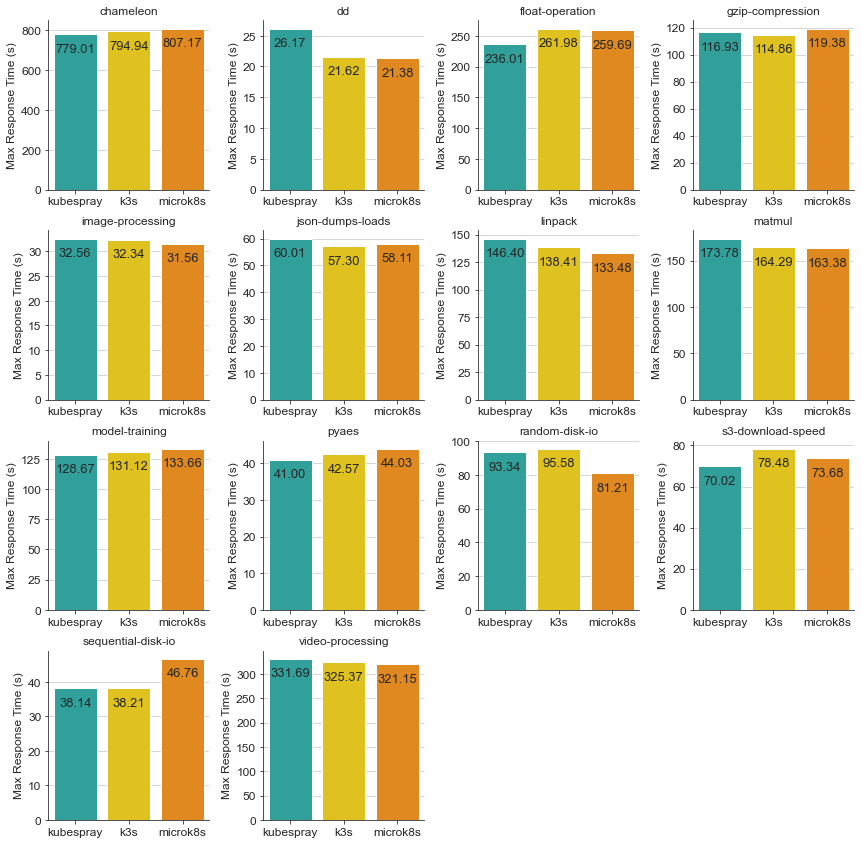

In [30]:
parallel_single_worker_total_bar_plot = sns.FacetGrid(
    df_parallel_single_worker.groupby(['test_name', 'test_type_description', 'test_platform']).max().reset_index(),
    col="test_name", hue='test_platform',col_wrap=4, sharey=False, palette=['gold', 'lightseagreen', 'darkorange'],
    sharex=False)
parallel_single_worker_total_bar_plot = parallel_single_worker_total_bar_plot.map(sns.barplot, 'test_platform',
                                                                                  'response-time',
                                                                                  order=TEST_PLATFORMS)
parallel_single_worker_total_bar_plot.set_titles('{col_name}', size=12)
parallel_single_worker_total_bar_plot.fig.tight_layout(w_pad=3)
for ax in parallel_single_worker_total_bar_plot.axes.ravel():
    ax.set_ylabel('Max Response Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=13)
plt.show()

In [31]:
parallel_single_worker_total_bar_plot.savefig('03-04-parallel_single_worker_total_bar_plot', bbox_inches='tight', dpi=300)

Inferring how many requests can be served by a single replica at the same time for the following tests:

- `float-operation`
- `chameleon`
- `gzip-compression`
- `image-processing`
- `linpack`
- `matmul`
- `model-training`
- `pyaes`
- `video-processing`

These tests have been chosen because they do not depend on a network element, and are CPU bound.

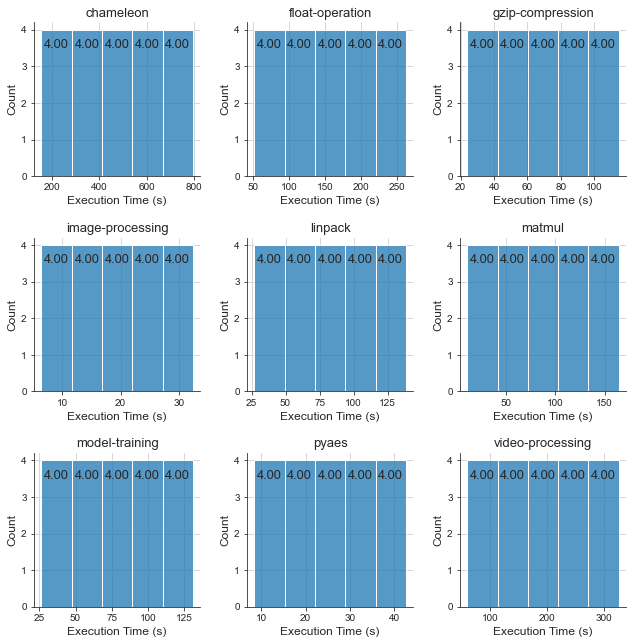

In [32]:
relevant_tests = ['float-operation', 'chameleon', 'gzip-compression', 'image-processing', 'linpack', 'matmul',
                  'model-training', 'pyaes', 'video-processing']
concurrency_inferrence_hist = sns.FacetGrid(df_parallel_single_worker[
                                                df_parallel_single_worker['test_platform'].eq('k3s') &
                                                df_parallel_single_worker['test_name'].isin(relevant_tests)],
                                            col="test_name", hue='test_platform', col_wrap=3, sharey=False,
                                            sharex=False)
concurrency_inferrence_hist = concurrency_inferrence_hist.map(sns.histplot, 'response-time', bins=5)
concurrency_inferrence_hist.set_titles('{col_name}', size=13)
plt.subplots_adjust(hspace=0.4)
for ax in concurrency_inferrence_hist.axes.ravel():
    ax.set_xlabel('Execution Time (s)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=13)
plt.show()

In [33]:
concurrency_inferrence_hist.savefig('03-06-concurrency_inferrence_hist', bbox_inches='tight', dpi=300)

Four requests at the same time. This value is also explained in the OpenFaaS docs and it is automatically determined based on the number of cores that the machine has.

## 04 - Analyzing autoscaling behavior using the native Alertmanager rules for OpenFaaS

The default rule tests the number of successful invocations per second for the last 10 seconds and if this number is larger than 5, it scales up the number of function instances up to a preconfigured maximum. This means that even when executing requests at a constant rate, say 6 per second, it is possible to obtain the maximum number of allowed replicas, same as when testing with a much larger number of requests per second, for example 30 or 40. We have tested this behavior by executing 1 request per second from 6 concurrent workers for more than 200 seconds, successfully reaching the defined threshold for the maximum number of replicas.

Since the default scaling rule does not take into account the current number of deployed replicas, instead it relies solely on the number of requests per second, it is binary in nature. Under a consistent load it either scales to the maximum number of configured replicas or it does not scale at all. However, as a result of using well-known third-party applications for the actual monitoring and rule definitions, administrators should be able with relative ease to change the default behavior in order to better reflect their needs.

## 05 - Analyzing autoscaling behavior using the Kubernetes Horizontal Pod Autoscaler (HPA)

In [34]:
df_hpa_parallel = pd.DataFrame()

Loading all the data into a single data frame...

In [35]:
tests = ['02_c=2-48+2_q=1_m=5', '03_c=40_-2_q=1_m=5', '04_c=varied_q=1_m=5']

test_type = '05'
test_type_description = 'hpa_parallel'

if os.path.sep == '/':
    regex_escape = '/'
else:
    regex_escape = '\\\\'

for platform in TEST_PLATFORMS:
    for test in tests:
        csv_files = glob.glob(f'data/{platform}/05-hpa-autoscaling/results/{test}/*scaling-c*.csv')
        for i in csv_files:
            test_name = re.findall(f'{regex_escape}(.*)-scaling.*.csv', i)[0]
            test_concurrency = re.findall(f'{regex_escape}.*-scaling-c(\d+).*.csv', i)[0]
            df_tmp = pd.read_csv(i)
            df_tmp = df_tmp[['response-time']]
            df_tmp['test_type'] = test_type
            df_tmp['test_type_description'] = test_type_description
            df_tmp['test_platform'] = platform
            df_tmp['test_name'] = test_name
            df_tmp['test_concurrency'] = test_concurrency
            df_tmp['test_iteration'] = test
            df_hpa_parallel = df_hpa_parallel.append(df_tmp)

The three tests that we will look at are:

- start with a single replica and increase the number of concurrent requests per second from 2 to 48. The number of concurrent requests per second is increased by 2 every 5 minutes.
- start with a single replica and decrease the number of concurrent requests per second from 40 to 1. The number of concurrent requests per second is decreased by 2 every 5 minutes.
- start with a single replica and vary the number of concurrent requests per second. The number of concurrent requests per second is changed every 5 minutes. This is the sequence for the number of concurrent requests per second that was used: `[8, 1, 20, 4, 40, 24, 1, 4, 16, 1, 36, 32]`

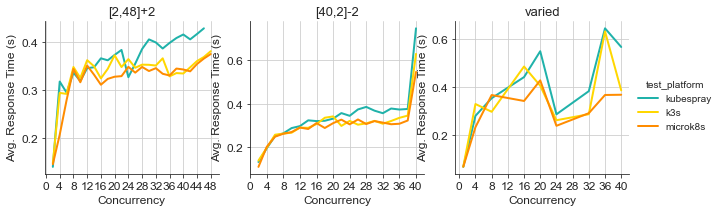

In [36]:
concurrency_mean = df_hpa_parallel.groupby(
    ['test_name', 'test_type', 'test_type_description', 'test_iteration', 'test_platform',
     'test_concurrency']).mean().reset_index()
concurrency_mean['test_concurrency'] = pd.to_numeric(concurrency_mean['test_concurrency'])
concurrency_mean['test_iteration'] = concurrency_mean['test_iteration'].replace(['02_c=2-48+2_q=1_m=5'], '[2,48]+2')
concurrency_mean['test_iteration'] = concurrency_mean['test_iteration'].replace(['03_c=40_-2_q=1_m=5'], '[40,2]-2')
concurrency_mean['test_iteration'] = concurrency_mean['test_iteration'].replace(['04_c=varied_q=1_m=5'], 'varied')
hpa_concurrency_line_plot = sns.FacetGrid(concurrency_mean, col="test_iteration", hue='test_platform', col_wrap=3,
                                          sharey=False, sharex=False, legend_out=True, hue_order=TEST_PLATFORMS, palette=['lightseagreen', 'gold', 'darkorange'])
hpa_concurrency_line_plot = hpa_concurrency_line_plot.map(sns.lineplot, 'test_concurrency', 'response-time', linewidth = 2)
hpa_concurrency_line_plot.set_titles('{col_name}', size=13)
hpa_concurrency_line_plot.add_legend()
c = 0
for ax in hpa_concurrency_line_plot.axes.ravel():
    ax.set_xlabel('Concurrency', fontsize=12)
    ax.set_ylabel('Avg. Response Time (s)', fontsize=12)
    ax.tick_params(labelsize=12)
    if c == 0:
        ax.set_xticks(range(0, 49, 4))
    else:
        ax.set_xticks(range(0, 41, 4))
    c += 1
plt.show()

In [37]:
hpa_concurrency_line_plot.savefig('05-07-hpa_concurrency_line_plot', bbox_inches='tight', dpi=300)

Visualizing how the number of replicas has changed with the change in the number of concurrent requests across time. The step chart below only shows the results for an initial load of 4 up to a maximum of 44 concurrent requsts per second, where the number of requests per second is increased by 4 every 5 minutes.

The raw data for this chart is available in `{platform_name}/05-hpa-autoscaling/results/01_c=4-48+4_q=1_m=5/float-operation-scaling.csv`.

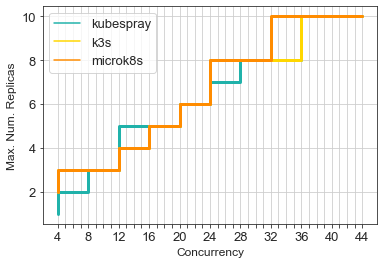

In [38]:
concurrency_4 = pd.DataFrame({
    'load': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44],
    'kubespray': [1, 2, 3, 5, 5, 6, 7, 8, 8, 10, 10],
    'k3s': [2, 3, 3, 4, 5, 6, 8, 8, 8, 10, 10],
    'microk8s': [2, 3, 3, 4, 5, 6, 8, 8, 10, 10, 10]
})
sns.set_style("ticks",{'axes.grid' : True})
concurrency_4_step_plot = sns.lineplot(data=pd.melt(concurrency_4, ['load'], var_name='platform'), x='load', y='value', hue='platform', drawstyle='steps-pre', palette=['lightseagreen', 'gold', 'darkorange'], linewidth = 3)
concurrency_4_step_plot.set_xticks(range(4, 45))
concurrency_4_step_plot.tick_params(labelsize=13)
concurrency_4_step_plot.set_ylabel('Max. Num. Replicas', fontsize=12)
concurrency_4_step_plot.set_xlabel('Concurrency', fontsize=12)
concurrency_4_step_plot.legend(fontsize=13)

for ind, label in enumerate(concurrency_4_step_plot.get_xticklabels()):
    if int(ind) % 4 == 0:  # keep every 4th tick label because that's the rate of increase
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()

In [39]:
fig = concurrency_4_step_plot.get_figure()
fig.savefig('05-08-concurrency_4_step_plot', bbox_inches='tight', dpi=300)

We see that the scale-up pattern of both K3s and MicroK8s is closely matched, with a difference shown only between the `32` and `36` concurrent load, while Kubespray is faster to scale up for `12` concurrent requests, but slower to scale up for `4` and `24`.